# Efficient object detection with OpenVINO™

There are a lot of object detection models with great precision and performance, but when it comes to applications, the model's scalability and efficiency also play a crucial role. Most object detection models have a ton of parameters and depth, which may increase accuracy but compromise inference-speed. This might go unnoticed in isolated inferences but becomes significant in real-time inferences like detecting and streaming live videos.

There are few object detection models that are considered efficient, scalable, and achieve state-of-the-art accuracy. EfficientDet is one of them, it was published by the Google Brain team with the goal of crystallizing architecture decisions into a scalable framework that can be easily applied to other use cases in object detection. The paper concludes that EfficientDet outperforms similar-sized models on benchmark datasets.

Research Paper : [EfficientDet: Scalable and Efficient Object Detection](https://openaccess.thecvf.com/content_CVPR_2020/papers/Tan_EfficientDet_Scalable_and_Efficient_Object_Detection_CVPR_2020_paper.pdf)\
Official GitHub : [EfficientDet](https://github.com/google/automl/tree/master/efficientdet)

EfficientDets are a family of object detection models, which achieve state-of-the-art 55.1mAP on COCO test-dev, yet being 4x - 9x smaller and using 13x - 42x fewer FLOPs than previous detectors. EfficientDet models also run 2x - 4x faster on GPU, and 5x - 11x faster on CPU than other detectors.

![Model_structure](https://raw.githubusercontent.com/google/automl/master/efficientdet/g3doc/network.png)
![Params](https://user-images.githubusercontent.com/71766106/226909727-2d321609-9c2c-4e25-a43a-6555778408d6.png)


### This notebook demonstrates:

* Downloading and using EfficientDet-d0 with TensorFlow-HUB.
* Converting the EfficientDet tf-model to OpenVINO-IR (Intermediate representation) file. Then, it's inference with OpenVINO runtime.
* Validating accuracy on COCO dataset.


### Prerequisites

In [ ]:
# dependencies
!pip install openvino-dev[tensorflow2]==2022.3.0 tensorflow-hub==0.13.0 pycocotools==2.0.6

In [5]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

import cv2
import matplotlib.pyplot as plt

import pathlib
import json
import sys
from zipfile import ZipFile

sys.path.append('../utils/')
from notebook_utils import load_image , download_file

## Downloading pre-trained EfficientDet model

* Download a pre-trained model of EfficientDet with help of tensorflow_hub API.
* [TensorFlow Hub](https://tfhub.dev/) is a repository of reusable assets for machine learning with TensorFlow. In particular, it provides pre-trained SavedModels that can be reused to solve new tasks with less training time and less training data.
* You can choose any model from the EfficientDet family, right now you will use efficientdet-d0 for this notebook.

In [ ]:
efficientDet_d0 = 'https://tfhub.dev/tensorflow/efficientdet/d0/1'
model = hub.load(efficientDet_d0)

#### Utility Functions


In [32]:
# COCO-2017 label
coco_label = {0:'__background__',1: 'person',2: 'bicycle',3: 'car',4: 'motorcycle',5: 'airplane',6: 'bus',7: 'train',8: 'truck',9: 'boat',
              10: 'traffic light',11: 'fire hydrant',12: 'street sign',13: 'stop sign',14: 'parking meter',15: 'bench',16: 'bird',
              17: 'cat',18: 'dog',19: 'horse',20: 'sheep',21: 'cow',22: 'elephant',23: 'bear',24: 'zebra',25: 'giraffe',
              26: 'hat',27: 'backpack',28: 'umbrella',29: 'shoe',30: 'eye glasses',31: 'handbag',32: 'tie',33: 'suitcase',34: 'frisbee',
              35: 'skis',36: 'snowboard',37: 'sports ball',38: 'kite',39: 'baseball bat',40: 'baseball glove',41: 'skateboard',42: 'surfboard',
              43: 'tennis racket',44: 'bottle',45: 'plate',46: 'wine glass',47: 'cup',48: 'fork',49: 'knife',50: 'spoon',51: 'bowl',
              52: 'banana',53: 'apple',54: 'sandwich',55: 'orange',56: 'broccoli',57: 'carrot',58: 'hot dog',59: 'pizza',60: 'donut',
              61: 'cake',62: 'chair',63: 'couch',64: 'potted plant',65: 'bed',66: 'mirror',67: 'dining table',68: 'window',69: 'desk',70: 'toilet',
              71: 'door',72: 'tv',73: 'laptop',74: 'mouse',75: 'remote',76: 'keyboard',77: 'cell phone',78: 'microwave',79: 'oven',80: 'toaster',
              81: 'sink',82: 'refrigerator',83: 'blender',84: 'book',85: 'clock',86: 'vase',87: 'scissors',88: 'teddy bear',89: 'hair drier',90: 'toothbrush',91: 'hair brush',}

label_color = {i: [np.random.randint(0, 255) for _ in range(3)] for i in range(len(coco_label))}

In [33]:
def preprocess_image(image:np.ndarray):
    '''
    Load and preprocess image for EfficientDet model

    Parameters:
        image (np.ndarray) : image as a matrix
    Returns:
        img (np.ndarray) : input array of image after processing
    '''

    img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    img = img[np.newaxis,:,:,:]
    img = img.astype(np.uint8)

    return img

In [34]:
from typing import Dict


def draw_bbox(path:pathlib.Path ,pred:Dict ,n_bbox:int = 10,
              label:Dict[int,str] = coco_label,label_color:Dict[int,int] = label_color):
    '''
    Add Bounding-Box(BBOX) and labels over detected object in image

    1) Load image in cv2 for image manipulation
    2) Added BBOX and labels(COCO-2017)

    Parameters:
        cpath (Path) : complete path of image
        pred (np.ndarray) : predictions in format [id,x_min,y_min,x_max,y_max,confidence,label]
        n_bbox (int) : number of bbox on the image (first n will be choosen)
        label (Dict[int,str]) : mapping between class and class name
        label_color (Dict[int,int]) : mapping between class and class-drwaing-color

    Returns:
        im (np.ndarray) : image with bbox and labels
    '''
    
    if not isinstance(pred['detection_scores'],(np.ndarray)):
        scores = pred['detection_scores'].numpy().reshape(100)
        classes = pred['detection_classes'].numpy().reshape(100)
        bboxes = pred['detection_boxes'].numpy().reshape(100,4)
    else:
        scores = pred['detection_scores'].reshape(100)
        classes = pred['detection_classes'].reshape(100)
        bboxes = pred['detection_boxes'].reshape(100,4)

    img = load_image(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    h,w,c = img.shape

    for i in range(n_bbox):

        classs = classes[i]
        bbox = bboxes[i]
        score = scores[i]

        y_min ,x_min ,y_max ,x_max = bbox[0] * h ,bbox[1] * w ,bbox[2] * h ,bbox[3] * w

        # adding bbox to image
        img = cv2.rectangle(img=img,
                            pt1=(round(x_min),round(y_min)),
                            pt2=(round(x_max),round(y_max)),
                            color=label_color[classs],
                            thickness=2)
        
        # adding label and score over bbox
        img = cv2.putText(img=img,
                          text=f'{label[classs].upper()} {(score*100):.2f}%',
                          org=(round(x_min),round(y_min)),
                          fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                          fontScale=1,
                          color=label_color[classs],
                          thickness=2)
        
    return img

### TensorFlow model inference

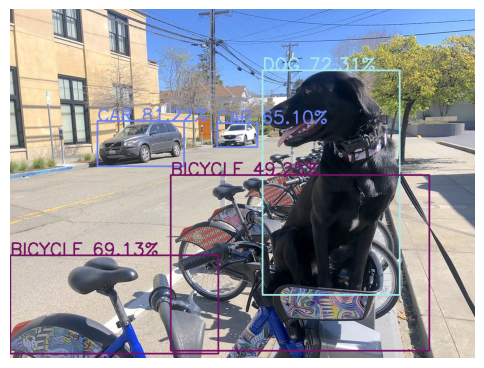

In [35]:
# loading image
image = load_image('../data/image/coco_bike.jpg')
image = preprocess_image(image)

# getting predictions
pred = model(image)

# visualizing result
image_bbox = draw_bbox(path='../data/image/coco_bike.jpg',pred=pred,n_bbox=5)
plt.figure(figsize=(6,6))
plt.imshow(image_bbox)
plt.axis(False)
plt.show()

To run a model with OpenVINO, you will need the trained model to be saved in any of the OpenVINO [supported fomats](https://docs.openvino.ai/latest/Supported_Model_Formats.html#supported-model-formats). OpenVINO has direct support for PaddlePaddle and ONNX models. Since your model is in Tensoflow, you will need an OpenVINO-IR file, for which you will save your model in TF SavedModel format and then convert it to OpenVINO-IR.

In [ ]:
# saving model
MODEL_DIR_PATH = pathlib.Path('SavedModel')
MODEL_DIR_PATH.mkdir(exist_ok=True)

tf.saved_model.save(model,str(MODEL_DIR_PATH))

## Convert model to OpenVINO Intermediate Representation
It is always useful to convert your model to OpenVINO-IR to take advantage of OpenVINO optimization tools and features. OpenVINO-IR consists of one XML file, which is a standardized file format for representing neural network models optimized for use with Intel hardware. This XML file can also be loaded into any platform with an OpenVINO inference engine and Intel hardware for further deployment.

In [12]:
IR_PATH = pathlib.Path('IR')
IR_PATH.mkdir(exist_ok=True)

In [ ]:
from openvino.tools import mo
from openvino.runtime import serialize

model_ir = mo.convert_model(saved_model_dir=str(MODEL_DIR_PATH))
XML_PATH = IR_PATH / 'efficientdet.xml'
serialize(model_ir,str(XML_PATH))

In [14]:
from openvino.runtime import Core

core = Core()
# read converted model
model_ir = core.read_model(model=XML_PATH)

# load model on CPU device
compiled_model = core.compile_model(model_ir, 'CPU')

# save keys of required information
CLASS_KEY = compiled_model.output(4)  
BBOX_KEY = compiled_model.output(3)
SCORE_KEY = compiled_model.output(6)

### OpenVINO model inference
To test model inference, create an inference pipeline with the help of the above-defined utility functions\
The pipeline consists of :-
* Preprocessing : Since the model expects the image to be in RGB, with shape [1,height, width,3] and values in UINT8 data type.
* Inference of OpenVINO model.
* Post-processing : Since the model returns a lot of information like `detection_scores`, `raw_detection_scores`, `raw_detection_classes`, `num_detection` , etc. Therefore , you need to post-process results to gather only required information like score (confidence) , classes, and bounding boxes.

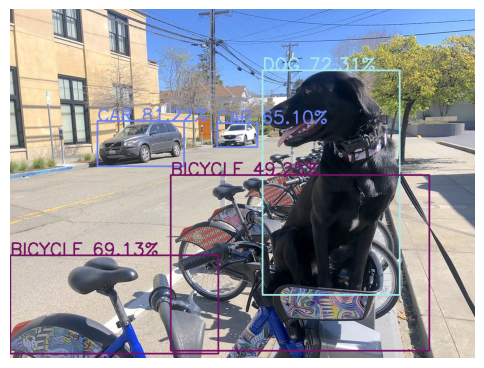

In [36]:
# loading and pre-processing image
image = load_image('../data/image/coco_bike.jpg')
image = preprocess_image(image)

# producing result
result = compiled_model([image])
result_dict = {'detection_scores':result[SCORE_KEY],
               'detection_classes':result[CLASS_KEY],
               'detection_boxes':result[BBOX_KEY]}

# visualizing result
image_bbox = draw_bbox(path='../data/image/coco_bike.jpg',pred=result_dict,n_bbox=5)
plt.figure(figsize=(6,6))
plt.imshow(image_bbox)
plt.axis(False)
plt.show()

## Verify model accuracy
Since EfficientDet models are trained with [COCO-2017](https://cocodataset.org/#download) dataset, you will use its validation dataset to verify accuracy. To evaluate performance, you will use the AP metric ie. Average Precision for which you will use the COCO official API called [pycocotools](https://github.com/cocodataset/cocoapi/tree/master/PythonAPI/pycocotools).
Pycocotools requires predictions in COCO format, so you will save your predictions in COCO format.


In [ ]:
# Downloading images and labels of COCO-VAL2017

DATA_URL = 'http://images.cocodataset.org/zips/val2017.zip'
LABELS_URL = 'https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip'

OUT_DIR = pathlib.Path.cwd() / 'data'
OUT_DIR.mkdir(exist_ok=True)

if not (OUT_DIR / 'coco/labels').exists():
    download_file(url=DATA_URL,directory=str(OUT_DIR))
    download_file(url=LABELS_URL,directory=str(OUT_DIR))
    with ZipFile('data/coco2017labels-segments.zip' , 'r') as zip_ref:
        zip_ref.extractall(OUT_DIR)
    with ZipFile('data/val2017.zip' , 'r') as zip_ref:
        zip_ref.extractall(OUT_DIR / 'coco/images')

In [17]:
from openvino.runtime import Model


def write_result(model:Model,image_dir:pathlib.Path,res_file:str,n_images:int = 100):
    '''
    Create a JSON file with predictions in COCO format to evalute AP

    Parameters:
        model(Model) : openvino 
        images_dir(Path) : Path of images directory
        res_file(str) : result file name 
        n_images(int) : number of images for which predictions must be wrote (first n)
    
    Returns:
        NONE
    '''
    
    results = []
    images = sorted(pathlib.os.listdir(image_dir))[100:100 + n_images]  # n_images

    # loop for finding result for each of n_images
    for _,i in enumerate(images, start=1):

        complete_path = pathlib.Path(image_dir) / i
        img = load_image(str(complete_path))
        img_tensor = preprocess_image(img)

        result = model([img_tensor])

        cat_ids ,scores, bboxs = result[CLASS_KEY][0] , result[SCORE_KEY][0] , result[BBOX_KEY][0]

        for k in range(len(cat_ids)):

            __,h,w,c = img_tensor.shape
            score , cat_id , bbox = scores[k] , cat_ids[k] , bboxs[k]
            y_min ,x_min ,y_max ,x_max = bbox[0] * h ,bbox[1] * w ,bbox[2] * h ,bbox[3] * w

            # storing result in COCO format
            r = {'score':np.float64(score),
                 'image_id':int(i[:len(i) - 4]),
                 'category_id':int(cat_id),
                 'bbox':list(np.array([x_min, y_min , x_max - x_min, y_max - y_min]).astype(np.float64))}

            results.append(r)

        if (_ % 10 == 0):
            print(f'{_}/{n_images} predictions stored ')
    
    with open(res_file,'w') as result_file:
        json.dump(results,result_file)

Since Pycocotool requires predictions to be in COCO format, the cell below will store predictions for 100 images in COCO format with `write_result` function. Further Pycocotool will evaluate prediction and return the model's performance.

In [ ]:
# writing predictions
images_folder = pathlib.Path('data/coco/images/val2017')
result_file = 'result.json'
write_result(model=compiled_model,image_dir=images_folder,res_file=result_file,n_images=100)

In [19]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

annType = 'bbox'

cocoGT = COCO('data/coco/annotations/instances_val2017.json')
cocoDT = cocoGT.loadRes('result.json')

imgIds = sorted(cocoGT.getImgIds())
imgIds = imgIds[100:200]  # using 100-200 ids as model is being evaluated on those images only

cocoEval = COCOeval(cocoGT,cocoDT,annType)
cocoEval.params.imgIds = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=2.82s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.11s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.23s).
Accumulating evaluation results...
DONE (t=1.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.402
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.580
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.432
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.148
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.478
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.687
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.495
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets